IMPORT

In [1]:
import numpy as np
import glob
import sys
import os
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import glob
import math
from scipy.optimize import curve_fit

Input path

In [2]:
folder = "/home/clowis/cernbox/cern_data/CTR bench analysis/2x2x20bgo/"

names, correction, options

In [3]:
c_name =       ["F1","F2","F3","F4","F5","F6","F10","F11","F12"]
#int_energy_left_nVs and int_energy_right_nVs have to be included
new_name =     ["max_energy_left_mV",
                "max_energy_right_mV",
                "delta_t_ps",
                "RMS_left_mV",
                "int_energy_left_nVs",
                "int_energy_right_nVs",
                "RMS_right_mV",
                "rise_t_left_ps",
                "rise_t_right_ps"]
corr_factor =  [-1e3,-1e3,1e12,1e3,-1e9,-1e9,1e3,1e12,1e12]
show_plots = True
#photopeak fitting range
up = 665/511
down = 440/511

Combine files

In [4]:
rm_comb = glob.glob(folder+"*_combined.txt")
for i in range(len(rm_comb)):
    os.remove(rm_comb[i])

first_files = glob.glob(folder+"*00000.txt")
all_files = glob.glob(folder+"*.txt")
other_files = list(set(all_files) - set(first_files))
num = int(len(all_files)/len(first_files))

for i in range(len(first_files)):
    with open(first_files[i][:-9]+"_combined.txt", mode = "w") as comb_txt:
        with open(first_files[i]) as first:
            temp_first = first.readlines() 
            
            for line in range(len(temp_first)-5):
                comb_txt.write(temp_first[line+5])
                
            for j in range(len(other_files)):
                if first_files[i][:-9] == other_files[j][:-9]:
                    with open(other_files[j]) as next:
                        temp_next = next.readlines()
                        for line in range(len(temp_next)-5):
                            comb_txt.write(temp_next[line+5])

transform data in dataframe

In [5]:
data = pd.DataFrame()
combined_files = glob.glob(folder+"*_combined.txt")
for i in range(len(combined_files)):
    temp = []
    with open(combined_files[i]) as f:
        temp = f.readlines()
        for j in range(len(temp)):
            temp[j] = temp[j][temp[j].find(";")+1:-1]
            name = combined_files[i][combined_files[i].find("/F")+1:combined_files[i].find("V-")-2]
            data[name] = temp

rm_comb = glob.glob(folder+"*_combined.txt")
for i in range(len(rm_comb)):
    os.remove(rm_comb[i])

transform DataFrame str to fload and remove entries with corrupted information

In [6]:
rows = []
for col in range(len(data.columns)):
    for row in range(len(data)):
        if data.iloc[row,col] == "-1.#IND":
            rows.append(row)

data = data.drop(rows)
data = data.reset_index(drop=True)

for col in range(len(data.columns)):
    for row in range(len(data)):
        data.iloc[row,col] = float(data.iloc[row,col])
        

rename columns and add units

In [7]:
for i in range(len(c_name)):
    data = data.rename(columns={c_name[i]: new_name[i]})
    data.loc[:,new_name[i]] = data.loc[:,new_name[i]] * corr_factor[i]

Histogramms 

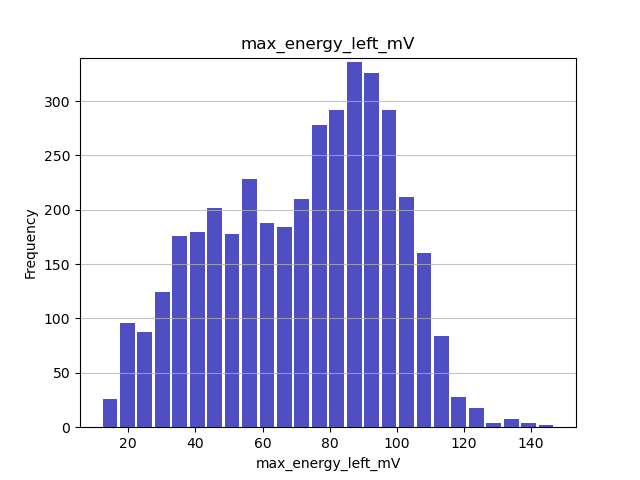

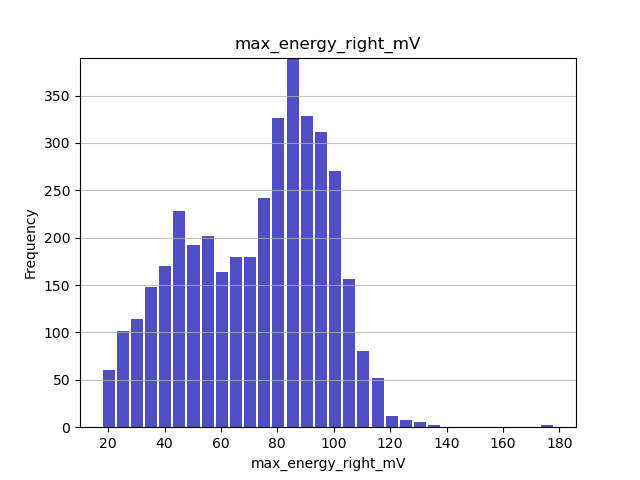

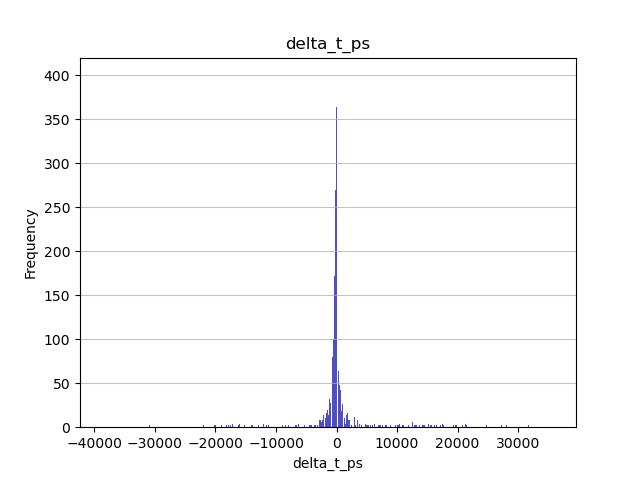

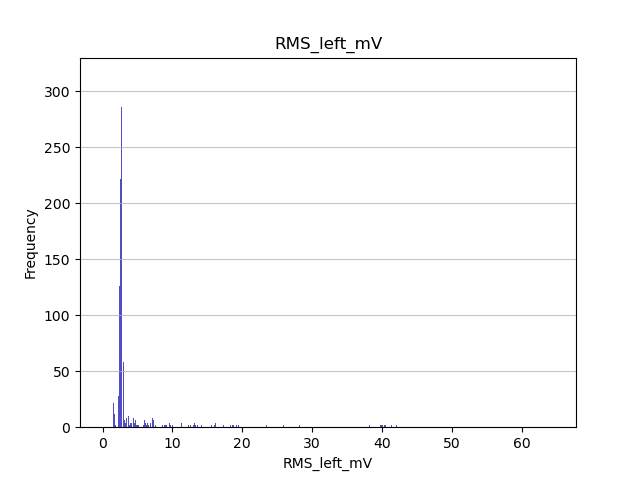

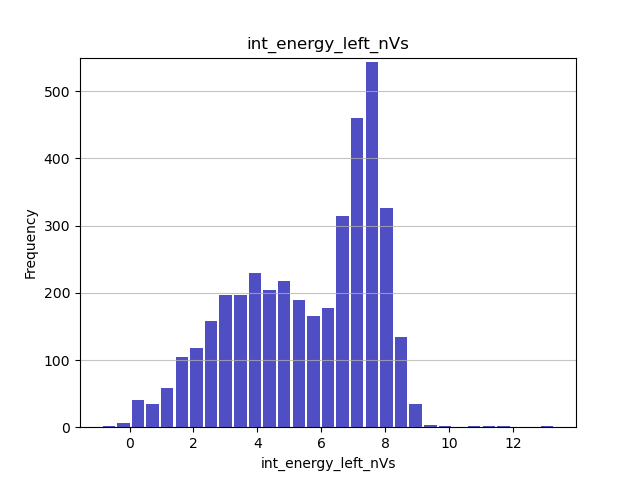

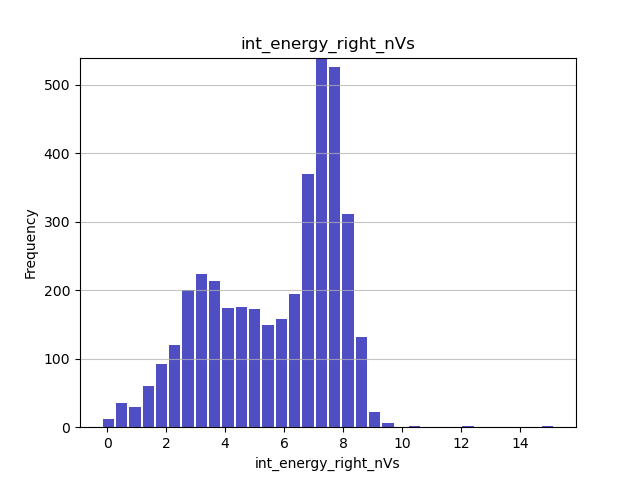

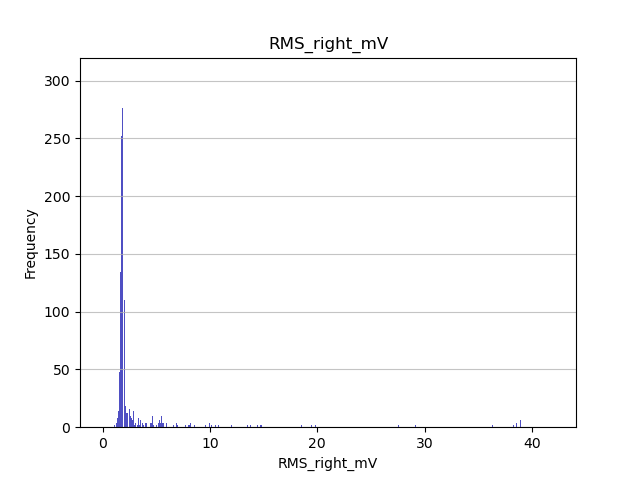

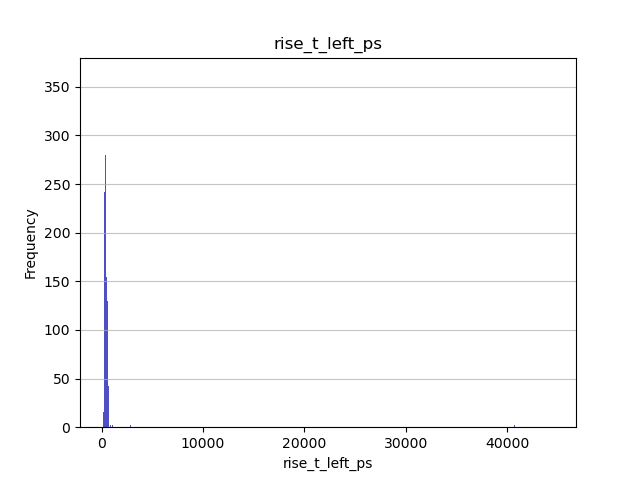

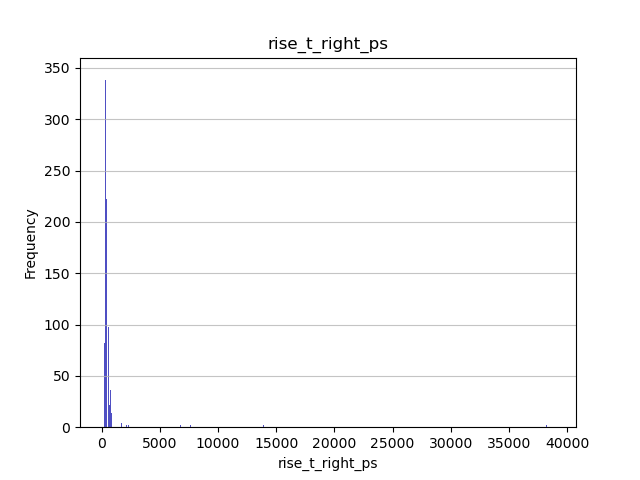

In [8]:
hist_data = pd.DataFrame()
%matplotlib widget
if show_plots == False:
    print("Plots are off")
    
for i in range(len(new_name)):
    
    x = new_name[i]
    
    q1 = pd.Series(data[x]).quantile(0.25)
    q3 = pd.Series(data[x]).quantile(0.75)
    iqr = q3 - q1
    bin_width = (2 * iqr) / (len(pd.Series(data[x])) ** (1 / 3))
    bin_count = int(np.ceil((pd.Series(data[x]).max() - pd.Series(data[x]).min()) / bin_width))

    x = new_name[i]
    plt.figure(x)
    n, bins, patches = plt.hist(list(data[x]), bins=bin_count, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(x)
    plt.ylabel('Frequency')
    plt.title(x)
    plt.text(23, 45, '')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

    additional = pd.DataFrame({str("n_" + x): n})
    hist_data = pd.concat([hist_data, additional], axis=1) 

    patches_list = []
    for j in patches:
        patches_list.append(j.get_x()+j.get_width()/2)
    additional = pd.DataFrame({str("x_" + x): patches_list})
    hist_data = pd.concat([hist_data, additional], axis=1)
    if show_plots == False:
        plt.close()

Energy fit

In [14]:
#define functions
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Compton(x, a, b, c):
    return a / np.sqrt(1 + np.power((x / np.abs(b)), c))

# Energy fit compton+gauss a,b,c -> gauss d,e,f ->compton
def Energy_fit(x, a, b, c, d, e, f):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d / np.sqrt(1 + np.power((x / np.abs(e)), f))

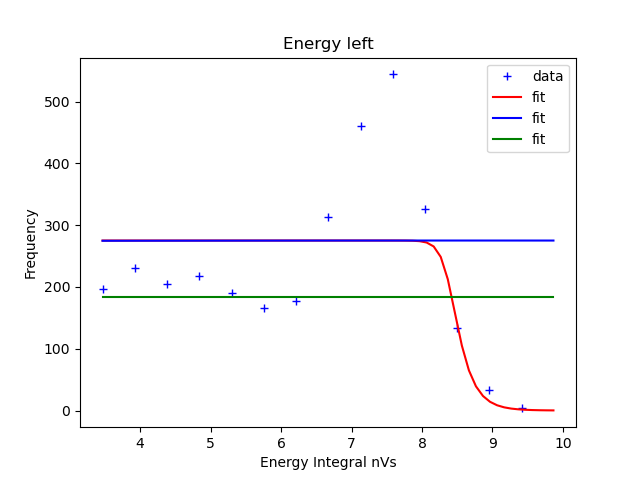

In [15]:
plt.figure("Energy_left")
max_n = np.max(hist_data.n_int_energy_left_nVs)
max_ind = int(hist_data[hist_data.n_int_energy_left_nVs==max_n].index.values)
max_x = hist_data.x_int_energy_left_nVs[max_ind]
upper_x = min(hist_data.x_int_energy_left_nVs, key=lambda x:abs(x-max_x*up))
lower_x = min(hist_data.x_int_energy_left_nVs, key=lambda x:abs(x-max_x*down))
upper_ind = int(hist_data[hist_data.x_int_energy_left_nVs==upper_x].index.values)
lower_ind = int(hist_data[hist_data.x_int_energy_left_nVs==lower_x].index.values)
c_max_n = np.max(hist_data.n_int_energy_left_nVs[:lower_ind])
c_max_ind = int(hist_data[hist_data.n_int_energy_left_nVs==c_max_n].index.values)
c_lower_ind = int(c_max_ind * 0.9)
c_upper_ind = int(lower_ind * 1)

x = np.array(hist_data.x_int_energy_right_nVs[lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[lower_ind:upper_ind])
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
a = 1
b = mean
c = sigma

x = np.array(hist_data.x_int_energy_right_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[c_lower_ind:c_upper_ind])
d = np.max(y)
e = hist_data.x_int_energy_right_nVs[int(c_upper_ind*0.9)]
f = 5

x = np.array(hist_data.x_int_energy_left_nVs[c_lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[c_lower_ind:upper_ind])
x_fit_left = np.arange(hist_data.x_int_energy_left_nVs[c_lower_ind],hist_data.x_int_energy_left_nVs[upper_ind],0.1)

popt_left,pcov = curve_fit(Energy_fit, x, y, p0=[a,b,c,d,e,f])
y_fit_left = Gauss(x_fit_left, popt_left[3], popt_left[4], popt_left[5])

if show_plots == True:
    plt.close()
    plt.figure("Energy fit left")
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x_fit_left, Energy_fit(x_fit_left, *popt_left), 'r-', label='fit')
    plt.plot(x_fit_left, Gauss(x_fit_left, popt_left[3], popt_left[4], popt_left[5]), 'b-', label='fit')
    plt.plot(x_fit_left, Compton(x_fit_left, popt_left[0], popt_left[1], popt_left[2]), 'g-', label='fit')
    plt.legend()
    plt.title('Energy left')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

In [11]:
#Energy fit left
plt.figure("Energy_left")
max_n = np.max(hist_data.n_int_energy_left_nVs)
max_ind = int(hist_data[hist_data.n_int_energy_left_nVs==max_n].index.values)
max_x = hist_data.x_int_energy_left_nVs[max_ind]
upper_x = min(hist_data.x_int_energy_left_nVs, key=lambda x:abs(x-max_x*up))
lower_x = min(hist_data.x_int_energy_left_nVs, key=lambda x:abs(x-max_x*down))
upper_ind = int(hist_data[hist_data.x_int_energy_left_nVs==upper_x].index.values)
lower_ind = int(hist_data[hist_data.x_int_energy_left_nVs==lower_x].index.values)
c_max_n = np.max(hist_data.n_int_energy_left_nVs[:lower_ind])
c_max_ind = int(hist_data[hist_data.n_int_energy_left_nVs==c_max_n].index.values)
c_lower_ind = int(c_max_ind * 0.9)
c_upper_ind = int(c_lower_ind * 1.1)

#quess values
x = np.array(hist_data.x_int_energy_left_nVs[lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[lower_ind:upper_ind])
a = np.max(y)
b = sum(x * y) / sum(y)
c = np.sqrt(sum(y * (x - b)**2) / sum(y))
x = np.array(hist_data.x_int_energy_left_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[c_lower_ind:c_upper_ind])
d = np.max(y)
e = hist_data.x_int_energy_left_nVs[int(c_upper_ind)]
f = 1
x = np.array(hist_data.x_int_energy_left_nVs[c_lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[c_lower_ind:upper_ind])
x_fit_left = np.arange(hist_data.x_int_energy_left_nVs[c_lower_ind],hist_data.x_int_energy_left_nVs[upper_ind],0.1)

popt_left,pcov = curve_fit(Energy_fit, x, y, p0=[a,b,c,d,e,f])
y_fit_left = Gauss(x_fit_left, popt_left[3], popt_left[4], popt_left[5])

if show_plots == True:
    plt.close()
    plt.figure("Energy fit left")
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x_fit_left, Energy_fit(x_fit_left, *popt_left), 'r-', label='fit')
    plt.plot(x_fit_left, Gauss(x_fit_left, popt_left[3], popt_left[4], popt_left[5]), 'b-', label='fit')
    plt.plot(x_fit_left, Compton(x_fit_left, popt_left[0], popt_left[1], popt_left[2]), 'g-', label='fit')
    plt.legend()
    plt.title('Energy left')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
#Energy fit right
plt.figure("Energy_right")
max_n = np.max(hist_data.n_int_energy_right_nVs)
max_ind = int(hist_data[hist_data.n_int_energy_right_nVs==max_n].index.values)
max_x = hist_data.x_int_energy_right_nVs[max_ind]
upper_x = min(hist_data.x_int_energy_right_nVs, key=lambda x:abs(x-max_x*up))
lower_x = min(hist_data.x_int_energy_right_nVs, key=lambda x:abs(x-max_x*down))
upper_ind = int(hist_data[hist_data.x_int_energy_right_nVs==upper_x].index.values)
lower_ind = int(hist_data[hist_data.x_int_energy_right_nVs==lower_x].index.values)
c_max_n = np.max(hist_data.n_int_energy_right_nVs[:lower_ind])
c_max_ind = int(hist_data[hist_data.n_int_energy_right_nVs==c_max_n].index.values)
c_lower_ind = int(c_max_ind * 0.9)

#quess values
x = np.array(hist_data.x_int_energy_right_nVs[lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[lower_ind:upper_ind])
a = np.max(y)
b = sum(x * y) / sum(y)
c = np.sqrt(sum(y * (x - mean)**2) / sum(y))
x = np.array(hist_data.x_int_energy_right_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[c_lower_ind:c_upper_ind])
d = np.max(y)
e = hist_data.x_int_energy_right_nVs[int(c_upper_ind)]
f = 1
x = np.array(hist_data.x_int_energy_right_nVs[c_lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[c_lower_ind:upper_ind])
x_fit_right = np.arange(hist_data.x_int_energy_right_nVs[c_lower_ind],hist_data.x_int_energy_right_nVs[upper_ind],0.1)

popt_right,pcov = curve_fit(Energy_fit, x, y, p0=[a,b,c,d,e,f])
y_fit_right = Gauss(x_fit_right, popt_right[3], popt_right[4], popt_right[5])

if show_plots == True:
    plt.close()
    plt.figure("Energy fit right")
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x_fit_right, Energy_fit(x_fit_right, *popt_right), 'r-', label='fit')
    plt.plot(x_fit_right, Gauss(x_fit_right, popt_right[3], popt_right[4], popt_right[5]), 'b-', label='fit')
    plt.plot(x_fit_right, Compton(x_fit_right, popt_right[0], popt_right[1], popt_right[2]), 'g-', label='fit')
    plt.legend()
    plt.title('Energy right')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

Cut for 511 keV events

In [ ]:
cut_data = data
down = 0.95
up = 1.05
energy1_left = x_fit_left[list(y_fit_left).index(max(list(y_fit_left)))] * down
energy2_left = x_fit_left[list(y_fit_left).index(max(list(y_fit_left)))] * up
energy1_right= x_fit_right[list(y_fit_right).index(max(list(y_fit_right)))] * down
energy2_right= x_fit_right[list(y_fit_right).index(max(list(y_fit_right)))] * up

for i in range(len(cut_data)):
    left = cut_data.int_energy_left_nVs[i]
    right = cut_data.int_energy_right_nVs[i]
    if left < energy1_left or left > energy2_left or right < energy1_right or right > energy2_right:
        cut_data = cut_data.drop([i])



In [ ]:
np.std(cut_data.delta_t_ps)
len(cut_data)

In [ ]:
hist_data_cut = pd.DataFrame()
if show_plots == False:
    print("Plots are off")
    
for i in range(len(new_name)):
    
    x = new_name[i]
    
    q1 = pd.Series(cut_data[x]).quantile(0.25)
    q3 = pd.Series(cut_data[x]).quantile(0.75)
    iqr = q3 - q1
    bin_width = (2 * iqr) / (len(pd.Series(cut_data[x])) ** (1 / 3))
    bin_count = int(np.ceil((pd.Series(cut_data[x]).max() - pd.Series(cut_data[x]).min()) / bin_width))
    
    plt.figure(x + " - energy cut")
    n, bins, patches = plt.hist(list(cut_data[x]), bins=bin_count, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(x)
    plt.ylabel('Frequency')
    plt.title(x)
    plt.text(23, 45, '')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

    additional = pd.DataFrame({str("n_" + x): n})
    hist_data_cut = pd.concat([hist_data_cut, additional], axis=1) 

    patches_list = []
    for j in patches:
        patches_list.append(j.get_x()+j.get_width()/2)
    additional = pd.DataFrame({str("x_" + x): patches_list})
    hist_data_cut = pd.concat([hist_data_cut, additional], axis=1)
    if show_plots == False:
        plt.close()